# Imports

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset Preparation

## Function for RGB to frequency conversion

In [2]:
def rgb_to_fft(x):
    # x: [B, 3, H, W]  (already normalized)
    fft = torch.fft.fft2(x, dim=(-2, -1))
    fft = torch.fft.fftshift(fft, dim=(-2, -1))
    mag = torch.abs(fft)
    mag = torch.log1p(mag)
    return mag


## Custom datast for preprocessing

In [3]:
class MultiGenDataset(Dataset):
    def __init__(self, root_dir, split="val", transform=None):
        self.samples = []
        self.transform = transform

        generators = os.listdir(root_dir)

        for gen in generators:
            gen_path = os.path.join(root_dir, gen, split)
            if not os.path.isdir(gen_path):
                continue

            for cls in ["ai", "nature"]:
                class_dir = os.path.join(gen_path, cls)
                if not os.path.isdir(class_dir):
                    continue

                #Mapping: nature=REAL(0) ai=FAKE(1) 
                label = 1 if cls == "ai" else 0  

                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, label))

        assert len(self.samples) > 0, "Dataset is EMPTY"
        print(f"[{split}] Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label


## Val Transform

In [4]:
val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Val DataLoader

In [5]:
val_ds = MultiGenDataset(
    root_dir="/kaggle/input/tiny-genimage",
    split="val",
    transform=val_tf
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


[val] Loaded 7000 samples


# Load Trained Model from Path

In [6]:
def load_resnet34_freq_model(
    num_classes=2,
    freeze_layer2=False
):
    """
    ResNet-34 for frequency-domain branch.
    - ImageNet pretrained
    - Early layers frozen
    - Deeper layers trainable

    Args:
        num_classes (int): number of output classes
        freeze_layer2 (bool): whether to freeze layer2 as well

    Returns:
        model (nn.Module)
    """

    # 1. Load pretrained ResNet-34
    model = models.resnet34(
        weights=None
    )

    # 2. Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # 3. Freeze stem
    for p in model.conv1.parameters():
        p.requires_grad = False
    for p in model.bn1.parameters():
        p.requires_grad = False

    # 4. Freeze layer1
    for p in model.layer1.parameters():
        p.requires_grad = False

    # 5. Optionally freeze layer2
    if freeze_layer2:
        for p in model.layer2.parameters():
            p.requires_grad = False

    return model


## (A) Load model architecture

In [7]:
model = load_resnet34_freq_model(
    num_classes=2,
    freeze_layer2=False
)


## (B) Load checkpoint weights

In [8]:
ckpt_path="/kaggle/input/resnet34-frequency-modelv2/pytorch/default/1/model_resnet34_frequency (1).pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

# Case 1: Lightning-style checkpoint
if isinstance(ckpt, dict) and "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]

# Case 2: Plain PyTorch state_dict
else:
    state_dict = ckpt


In [9]:
if any(k.startswith("model.") for k in state_dict.keys()):
    state_dict = {
        k.replace("model.", ""): v
        for k, v in state_dict.items()
    }


In [10]:
model.load_state_dict(state_dict, strict=True)
device = torch.device("cuda")
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Validation / Inference Loop for Evaluation

In [11]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        imgs = rgb_to_fft(imgs)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        threshold = 0.36

        
        p_fake = probs[:, 1]          # Probability of Fake (AI) class is used as decision reference.
        preds = (p_fake >= threshold).long()

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_probs.append(probs[:, 1].cpu()) # Collect probabilities for the 'AI' class

In [12]:
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

# Evaluation

In [26]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        imgs = rgb_to_fft(imgs)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        threshold = 0.36

        
        p_fake = probs[:, 1]          # Probability of Fake (AI) class is used as decision reference.
        preds = (p_fake >= threshold).long()

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_probs.append(probs[:, 1].cpu()) # Collect probabilities for the 'AI' class

In [27]:
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

## Decision Critical Results

### Confusion Matrix

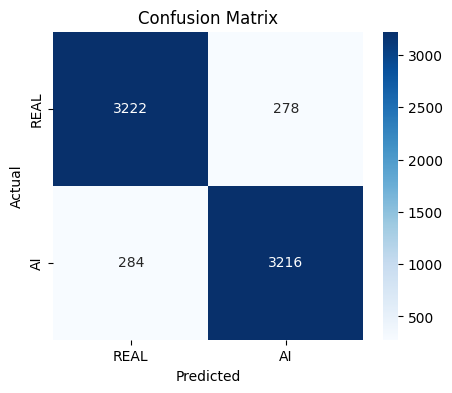

In [28]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["REAL", "AI"],
    yticklabels=["REAL", "AI"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Classification Report

In [29]:
print("New report:")

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["REAL", "AI"]
    )
)


New report:
              precision    recall  f1-score   support

        REAL       0.92      0.92      0.92      3500
          AI       0.92      0.92      0.92      3500

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000



### Threshold Sweeping (Decision boundary stress test)

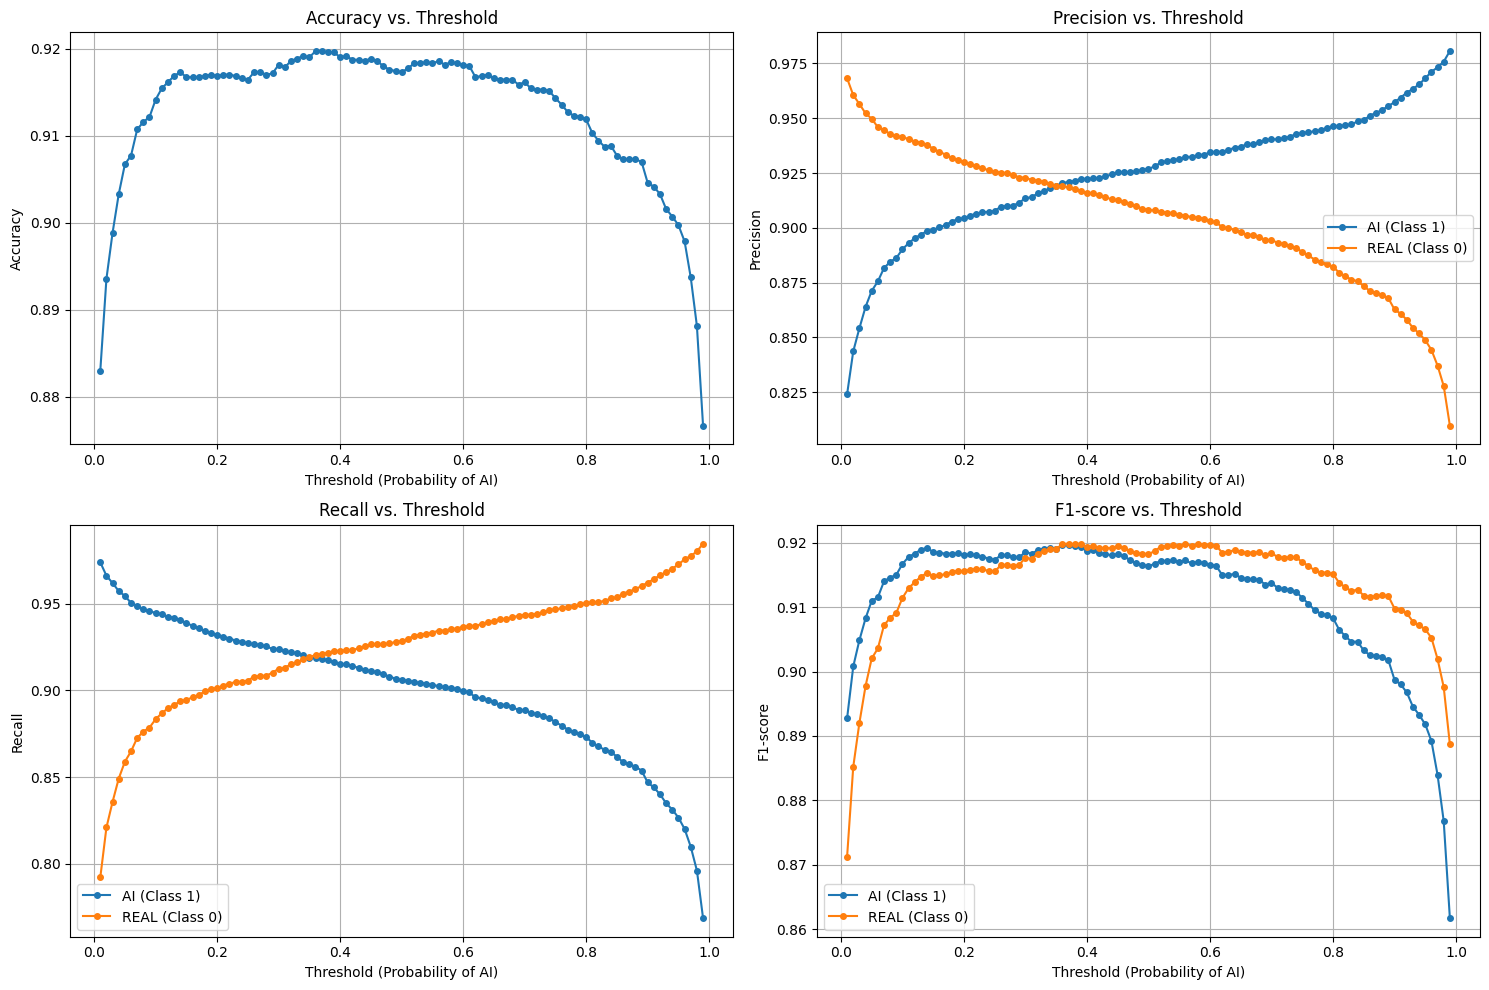


--- Impact of different thresholds on model performance ---


Overall highest metrics: 

Maximum overall accuracy of 0.9197 is achieved at threshold 0.36.
Highest Overall Precision (macro avg) (0.9197) is at threshold 0.37.
Highest Overall Recall (macro avg) (0.9197) is at threshold 0.36.
Highest Overall F1-score (macro avg) (0.9197) is at threshold 0.36.

Classwise highest metrics: 

Highest Precision for AI class (0.9807) is at threshold 0.99.
Highest Recall for AI class (0.9740) is at threshold 0.01.
Highest F1-score for AI class (0.9196) is at threshold 0.36.
Highest Precision for REAL class (0.9682) is at threshold 0.01.
Highest Recall for REAL class (0.9849) is at threshold 0.99.
Highest F1-score for REAL class (0.9199) is at threshold 0.56.

Observations:
 - As the threshold increases, precision for AI class generally increases (fewer false positives) while recall decreases (more false negatives).
 - Conversely, as the threshold increases, recall for REAL class generally increa

In [36]:
# --- Decision boundary stress test --- #

# Initialize lists to store metrics for plotting
accuracy_scores = []
precision_ai = []
recall_ai = []
f1_ai = []
precision_real = []
recall_real = []
f1_real = []

# New lists for overall (macro avg) metrics
overall_precision = []
overall_recall = []
overall_f1 = []

# Iterate through each threshold
for t in thresholds:
    # Calculate predictions based on the current threshold
    # Class 1 (AI) if probability of AI is >= threshold, else Class 0 (REAL)
    y_pred_thresholded = (y_prob >= t).astype(int)

    # Generate classification report for the current threshold
    report = classification_report(
        y_true,
        y_pred_thresholded,
        target_names=["REAL", "AI"],
        output_dict=True,
        zero_division=0 # Handle cases where precision/recall might be zero
    )

    # Store overall accuracy
    accuracy_scores.append(report['accuracy'])

    # Store metrics for AI class (class 1)
    precision_ai.append(report['AI']['precision'])
    recall_ai.append(report['AI']['recall'])
    f1_ai.append(report['AI']['f1-score'])

    # Store metrics for REAL class (class 0)
    precision_real.append(report['REAL']['precision'])
    recall_real.append(report['REAL']['recall'])
    f1_real.append(report['REAL']['f1-score'])

    # Store overall (macro avg) metrics
    overall_precision.append(report['macro avg']['precision'])
    overall_recall.append(report['macro avg']['recall'])
    overall_f1.append(report['macro avg']['f1-score'])

# --- Plotting the results --- #

plt.figure(figsize=(15, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(thresholds, accuracy_scores, marker='o', linestyle='-', markersize=4)
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(thresholds, precision_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, precision_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('Precision vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(thresholds, recall_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, recall_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Plot F1-score
plt.subplot(2, 2, 4)
plt.plot(thresholds, f1_ai, label='AI (Class 1)', marker='o', linestyle='-', markersize=4)
plt.plot(thresholds, f1_real, label='REAL (Class 0)', marker='o', linestyle='-', markersize=4)
plt.title('F1-score vs. Threshold')
plt.xlabel('Threshold (Probability of AI)')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Summary of Impact --- #

print("\n--- Impact of different thresholds on model performance ---\n")

print("\nOverall highest metrics: \n")
optimal_threshold_idx_acc = np.argmax(accuracy_scores)
optimal_threshold_acc = thresholds[optimal_threshold_idx_acc]
max_accuracy = accuracy_scores[optimal_threshold_idx_acc]
print(f"Maximum overall accuracy of {max_accuracy:.4f} is achieved at threshold {optimal_threshold_acc:.2f}.")

# Overall (macro avg) metrics
optimal_threshold_idx_overall_prec = np.argmax(overall_precision)
optimal_threshold_overall_prec = thresholds[optimal_threshold_idx_overall_prec]
max_overall_prec = overall_precision[optimal_threshold_idx_overall_prec]
print(f"Highest Overall Precision (macro avg) ({max_overall_prec:.4f}) is at threshold {optimal_threshold_overall_prec:.2f}.")

optimal_threshold_idx_overall_rec = np.argmax(overall_recall)
optimal_threshold_overall_rec = thresholds[optimal_threshold_idx_overall_rec]
max_overall_rec = overall_recall[optimal_threshold_idx_overall_rec]
print(f"Highest Overall Recall (macro avg) ({max_overall_rec:.4f}) is at threshold {optimal_threshold_overall_rec:.2f}.")

optimal_threshold_idx_overall_f1 = np.argmax(overall_f1)
optimal_threshold_overall_f1 = thresholds[optimal_threshold_idx_overall_f1]
max_overall_f1 = overall_f1[optimal_threshold_idx_overall_f1]
print(f"Highest Overall F1-score (macro avg) ({max_overall_f1:.4f}) is at threshold {optimal_threshold_overall_f1:.2f}.")

print("\nClasswise highest metrics: \n")
# Class-specific metrics (already present, keeping for completeness)
optimal_threshold_idx_prec_ai = np.argmax(precision_ai)
optimal_threshold_prec_ai = thresholds[optimal_threshold_idx_prec_ai]
max_prec_ai = precision_ai[optimal_threshold_idx_prec_ai]
print(f"Highest Precision for AI class ({max_prec_ai:.4f}) is at threshold {optimal_threshold_prec_ai:.2f}.")

optimal_threshold_idx_rec_ai = np.argmax(recall_ai)
optimal_threshold_rec_ai = thresholds[optimal_threshold_idx_rec_ai]
max_rec_ai = recall_ai[optimal_threshold_idx_rec_ai]
print(f"Highest Recall for AI class ({max_rec_ai:.4f}) is at threshold {optimal_threshold_rec_ai:.2f}.")

optimal_threshold_idx_f1_ai = np.argmax(f1_ai)
optimal_threshold_f1_ai = thresholds[optimal_threshold_idx_f1_ai]
max_f1_ai = f1_ai[optimal_threshold_idx_f1_ai]
print(f"Highest F1-score for AI class ({max_f1_ai:.4f}) is at threshold {optimal_threshold_f1_ai:.2f}.")

optimal_threshold_idx_prec_real = np.argmax(precision_real)
optimal_threshold_prec_real = thresholds[optimal_threshold_idx_prec_real]
max_prec_real = precision_real[optimal_threshold_idx_prec_real]
print(f"Highest Precision for REAL class ({max_prec_real:.4f}) is at threshold {optimal_threshold_prec_real:.2f}.")

optimal_threshold_idx_rec_real = np.argmax(recall_real)
optimal_threshold_rec_real = thresholds[optimal_threshold_idx_rec_real]
max_rec_real = recall_real[optimal_threshold_idx_rec_real]
print(f"Highest Recall for REAL class ({max_rec_real:.4f}) is at threshold {optimal_threshold_rec_real:.2f}.")

optimal_threshold_idx_f1_real = np.argmax(f1_real)
optimal_threshold_f1_real = thresholds[optimal_threshold_idx_f1_real]
max_f1_real = f1_real[optimal_threshold_idx_f1_real]
print(f"Highest F1-score for REAL class ({max_f1_real:.4f}) is at threshold {optimal_threshold_f1_real:.2f}.")

print("\nObservations:")
print(" - As the threshold increases, precision for AI class generally increases (fewer false positives) while recall decreases (more false negatives).")
print(" - Conversely, as the threshold increases, recall for REAL class generally increases while precision decreases.")
print(" - The choice of an optimal threshold depends on the specific goals of the application (e.g., minimizing false positives for AI, or minimizing false negatives for REAL).")


## Exploratory & Reference Diagnostics

### Generator-wise Evaluation

#### Updated MultiGenDataset class
MultiGenDataset now also returns gen_name.

In [ ]:
class MultiGenDatasetv2(Dataset):
    def __init__(self, root_dir, split="val", transform=None):
        self.samples = []
        self.transform = transform

        generators = os.listdir(root_dir)

        for gen in generators:
            gen_path = os.path.join(root_dir, gen, split)
            if not os.path.isdir(gen_path):
                continue

            for cls in ["ai", "nature"]:
                class_dir = os.path.join(gen_path, cls)
                if not os.path.isdir(class_dir):
                    continue

                #Mapping: nature=REAL(0) ai=FAKE(1)
                label = 1 if cls == "ai" else 0

                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    # Store generator name along with path and label
                    self.samples.append((img_path, label, gen))

        assert len(self.samples) > 0, "Dataset is EMPTY"
        print(f"[{split}] Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, gen_name = self.samples[idx] # Unpack gen_name
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img) # img is now a [C, H, W] tensor [0, 1]

        return img_fft, label, gen_name # Return gen_name as well

#### Updated DataLoader

In [16]:
gen_val_ds = MultiGenDatasetv2(
    root_dir="/kaggle/input/tiny-genimage",
    split="val",
    transform=val_tf
)

gen_val_loader = DataLoader(
    gen_val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

[val] Loaded 7000 samples


In [30]:
from collections import defaultdict

gen_stats = defaultdict(lambda: {"y": [], "p": []})

with torch.no_grad():
    for imgs, labels, gen_names in gen_val_loader:  # gen_names must be returned by dataset
        imgs = imgs.to(device)
        imgs = rgb_to_fft(imgs)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        threshold = 0.36 # Use the same updated threshold

        p_fake = probs[:, 1]
        preds = (p_fake >= threshold).long()

        for g, y, p in zip(gen_names, labels, preds):
            gen_stats[g]["y"].append(y.item())
            gen_stats[g]["p"].append(p.item())

In [31]:
for gen, d in gen_stats.items():
    print(f"\nGenerator: {gen}")
    print(classification_report(d["y"], d["p"]))



Generator: imagenet_ai_0424_wukong
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       500
           1       0.93      0.87      0.90       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000


Generator: imagenet_glide
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       500
           1       0.91      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000


Generator: imagenet_ai_0419_biggan
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       500
           1       0.94      1.00      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      

### Score distribution analysis

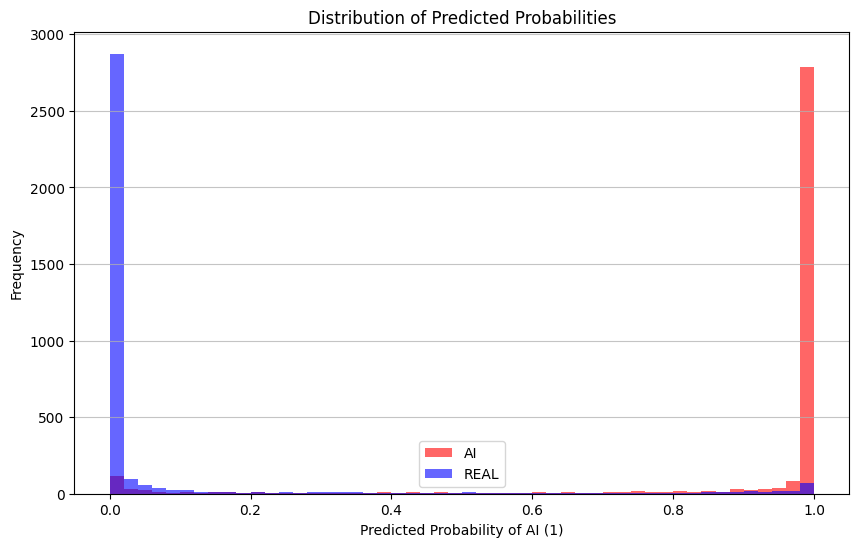

In [32]:
ai_probs = y_prob[y_true == 1]
real_probs = y_prob[y_true == 0]

plt.figure(figsize=(10, 6))
plt.hist(ai_probs, bins=50, alpha=0.6, label="AI", color='red')
plt.hist(real_probs, bins=50, alpha=0.6, label="REAL", color='blue')
plt.xlabel("Predicted Probability of AI (1)")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()


### Error probability statistics

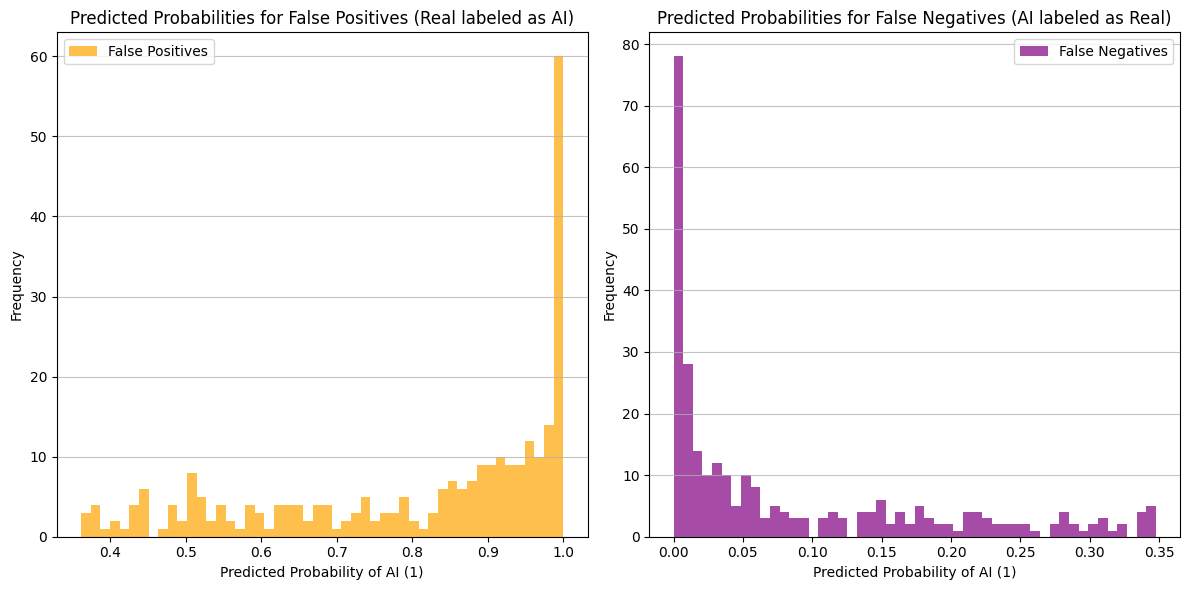

In [33]:
false_pos = np.where((y_true == 0) & (y_pred == 1))[0]
false_neg = np.where((y_true == 1) & (y_pred == 0))[0]

# Probabilities for false positives (Actual REAL, Predicted AI)
fp_probs = y_prob[false_pos]

# Probabilities for false negatives (Actual AI, Predicted REAL)
fn_probs = y_prob[false_neg]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fp_probs, bins=50, alpha=0.7, color='orange', label='False Positives')
plt.title('Predicted Probabilities for False Positives (Real labeled as AI)')
plt.xlabel('Predicted Probability of AI (1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
plt.hist(fn_probs, bins=50, alpha=0.7, color='purple', label='False Negatives')
plt.title('Predicted Probabilities for False Negatives (AI labeled as Real)')
plt.xlabel('Predicted Probability of AI (1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# AI -> Positive   Real -> Negative

### Generator Wise Testing (Chi squared statistics)

In [34]:
from scipy.stats import chi2_contingency
import pandas as pd

# Prepare data for Chi-squared test
# We want to see if the proportion of correct/incorrect classifications
# is independent of the generator.

contingency_table_data = []
generator_names = []

for gen, data in gen_stats.items():
    generator_names.append(gen)
    true_labels = np.array(data["y"])
    pred_labels = np.array(data["p"])

    correct_predictions = np.sum(true_labels == pred_labels)
    incorrect_predictions = np.sum(true_labels != pred_labels)

    contingency_table_data.append([correct_predictions, incorrect_predictions])

# Convert to a pandas DataFrame for better visualization (optional, but good for inspection)
contingency_df = pd.DataFrame(
    contingency_table_data,
    index=generator_names,
    columns=["Correct", "Incorrect"]
)

print("Contingency Table:")
display(contingency_df)

# Perform Chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_df)

print(f"\nChi-squared statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in classification performance across generators (reject H0).")
else:
    print("There is no statistically significant difference in classification performance across generators (fail to reject H0).")


Contingency Table:


,Correct,Incorrect
imagenet_ai_0424_wukong,904,96
imagenet_glide,951,49
imagenet_ai_0419_biggan,969,31
imagenet_ai_0419_vqdm,926,74
imagenet_midjourney,824,176
imagenet_ai_0424_sdv5,930,70
imagenet_ai_0508_adm,934,66



Chi-squared statistic: 178.2969
P-value: 0.0000
Degrees of Freedom: 6
There is a statistically significant difference in classification performance across generators (reject H0).


### Calibration Analysis

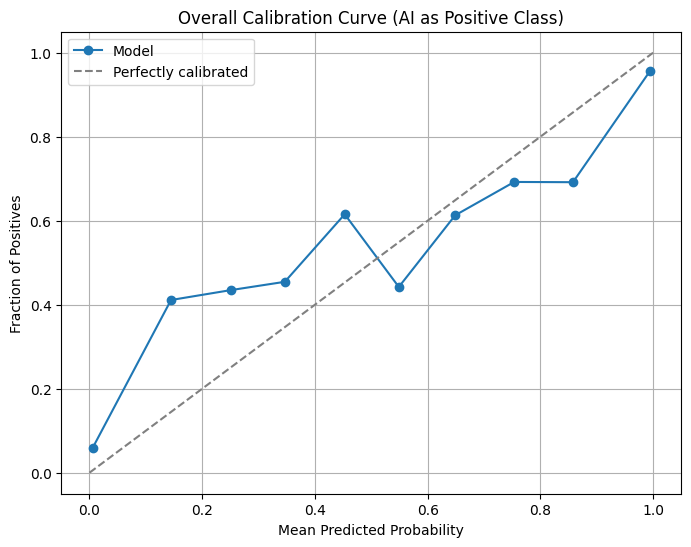

In [35]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10, title='Calibration Curve'):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot calibration curve for the entire dataset
plot_calibration_curve(y_true, y_prob, title='Overall Calibration Curve (AI as Positive Class)')